# Calculate the microburst CDF and PDF
Author: Mykahylo Shumko

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
WRITE_CDF_TO_FILE = True

CATALOG_VERSION = 6
CAT_PATH = ('/home/mike/research/ac6_microburst_scale_sizes/data/'
            'coincident_microbursts_catalogues/'
            'AC6_coincident_microbursts_sorted_v{}.txt'.format(CATALOG_VERSION))

In [4]:
bins = np.arange(0, 200, 5)       # Separation bins
CC_THRESH = 0.8                   # Temporal CC threshold
CURTAIN_THRESH = 0                # Amount by which the temporal CC must be greater than the spatial CC.
PEAK_STD_THRESH = None            # The number of standard deviations that a detection must be above a 10% 
                                  # Paul baseline.
WIDTH_THRESH = None               # Width threshold in units of %/100.

## Load catalog

In [5]:
cat = pd.read_csv(CAT_PATH)

In [6]:
print(cat.shape); cat.head()

(615, 20)


,dateTime,dos1rate,peak_std,Lm_OPQ,MLT_OPQ,lat,lon,alt,Dist_In_Track,Lag_In_Track,Dist_Total,Loss_Cone_Type,flag,AE,time_cc,space_cc,time_spatial_A,time_spatial_B,peak_width_A,peak_width_B
0,2015-04-16 04:50:47.600000,560.003,5.242196,5.36905,21.77790,-71.3883,-121.5450,660.860,131.796,17.4919,131.804,1.0,0.0,583.0,0.815984,0.061890,2015-04-16 04:50:47.600000,2015-04-16 04:51:05.091900,0.175007,0.197500
1,2015-04-16 05:37:42.100000,569.946,6.014335,5.03621,10.06720,65.7251,53.1518,674.671,132.305,17.5961,132.313,1.0,0.0,552.0,0.903722,0.470579,2015-04-16 05:37:42.100000,2015-04-16 05:37:59.696100,0.295886,0.260770
2,2015-04-16 07:15:41.600000,730.004,4.564616,5.12112,10.36750,65.3316,28.9745,674.543,131.850,17.5372,131.858,1.0,0.0,618.0,0.810201,0.063204,2015-04-16 07:15:24.062800,2015-04-16 07:15:41.600000,0.305028,0.210672
3,2015-04-16 19:29:05.400000,2590.010,6.070891,5.41519,19.99470,-64.5365,26.2792,662.745,128.400,17.0482,128.409,0.0,4.0,1023.0,0.823308,0.494986,2015-04-16 19:29:05.400000,2015-04-16 19:29:22.448200,0.310256,0.317107
4,2015-04-16 20:17:02.100000,600.003,8.760751,4.19432,8.38166,61.3247,-163.4740,672.074,129.070,17.1628,129.077,1.0,0.0,1249.0,0.812830,-0.521795,2015-04-16 20:16:44.937200,2015-04-16 20:17:02.100000,0.316239,0.290001


As a reference, what is the number of valid spatial and temporal CCs?

In [36]:
cat[(~np.isnan(cat['time_cc'])) & (~np.isnan(cat['space_cc']))].shape[0]

615

And now out of all of these detections, how many events had a temporal CC above CC_THRESH?

In [37]:
cat[cat['time_cc'] > CC_THRESH].shape[0]

615

## Load sampling dataset
The number of AC-6 seconds taken between separations a and b is given by the exposure, $E(a, b)$. The exposure is calculated by finding all 10 Hz data that were taking simulatenorusly by units A and B. Furthermore the dos1rate data cannot be negative i.e. not -1E31 error values, and the data flag = 0.

In [9]:
EXPOSURE_PATH = '/home/mike/research/ac6_microburst_scale_sizes/data/norm/ac6_norm_all_cdf.csv'
E = pd.read_csv(EXPOSURE_PATH, index_col=0)

In [10]:
E.head()

,Seconds
Separation [km],
0,37141.3
5,33107.2
10,9474.2
15,14304.5
20,9199.1


## Find coincident events
I define events that are coincident by the following criteria:
 - High temporal CC
 - Temporal CC > Spatial CC + CURTAIN_THRESH
 - Events inside the radition belt i.e. 4 < L < 8.
 - Not above US or the SAA
 - Optional: at least 2 standard deviations above the 10% baseline. This does not seem to influince the CDF much, but with this on the CDF is smoother.

First filter by high temporal CC

In [11]:
coincidentEvents = cat[cat['time_cc'] >= CC_THRESH]

Filter by L (only radiation belt)

In [12]:
coincidentEvents = coincidentEvents[(np.abs(coincidentEvents['Lm_OPQ']) > 4) & 
                                    (np.abs(coincidentEvents['Lm_OPQ']) < 8)]

Filter out curtains

In [13]:
coincidentEvents = coincidentEvents[coincidentEvents['time_cc'] > coincidentEvents['space_cc']+CURTAIN_THRESH]

Filter out detections made above the US to completely get rid of potential ground transmitter noise

In [14]:
coincidentEvents = coincidentEvents[
                ((coincidentEvents['lon'] > -60) | (coincidentEvents['lon'] < -140)) |
                ((coincidentEvents['lat'] > 70) | (coincidentEvents['lat'] < 15))
                                ]

Optional: filter events which were at least 2 standard deviations above the 10% baseline

In [16]:
if PEAK_STD_THRESH is not None:
    coincidentEvents = coincidentEvents[coincidentEvents['peak_std'] > PEAK_STD_THRESH]

Remove events with very different widths.

In [17]:
if WIDTH_THRESH is not None:
    coincidentEvents = coincidentEvents[np.isclose(coincidentEvents['peak_width_A'], 
                                               coincidentEvents['peak_width_B'], rtol=WIDTH_THRESH)]

### Sanity check: where were these detections made? 
This check makes sure that the US and SAA filters work correctly

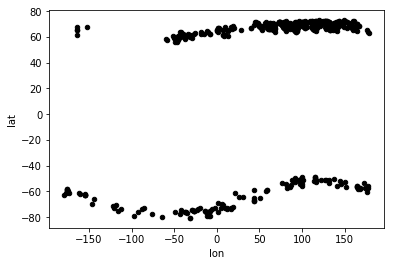

In [18]:
coincidentEvents.plot.scatter('lon', 'lat', c='k');

# Calculate the CDF Attempt 1
The microburst CDF at a separation $d$ is defined as the fraction of coincident microbursts observed at distance d to all the coincident microbursts in other words,

$$
CDF(d) = \frac{coincident > d}{all \ coincident}
$$

The intuitive way to think about this is with an example. When $d = 0$ km, the CDF = 1 i.e. 100% of microbursts were larger than $d$ and when $d = 25$ km the CDF = 0.4 i.e 40% of microbursts had a scale size larger than $d$.

First Calculate the total number of coincident microbursts

In [19]:
totalEvents = len(coincidentEvents); print(totalEvents)

615


Now iterate over each separation bin and calculate the CDF

In [20]:
cdf = np.array([(coincidentEvents['Dist_Total'] >= di).sum()/totalEvents for di in bins])
num = np.array([(coincidentEvents['Dist_Total'] >= di).sum() for di in bins])

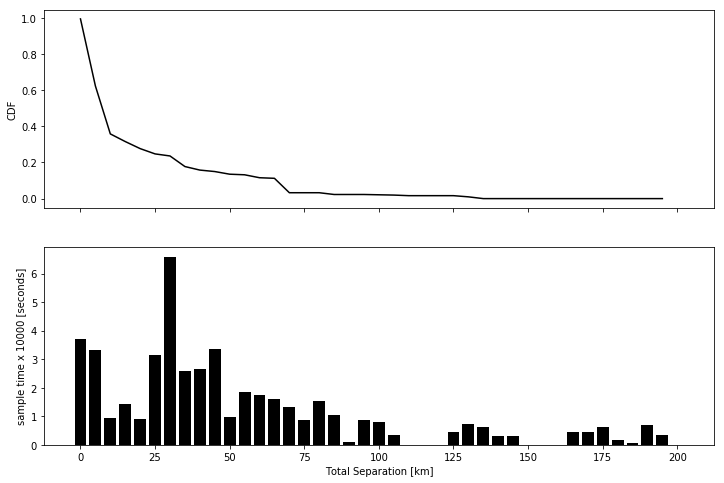

In [21]:
fig, ax = plt.subplots(2, sharex=True, figsize=(12, 8))
ax[0].plot(bins, cdf, 'k'); ax[0].set_ylabel('CDF');
ax[1].bar(E.loc[0:200].index, E['Seconds'].loc[0:200]/10000, width=0.8*E.index[1]-E.index[0], color='k')
ax[1].set_ylabel('sample time x 10000 [seconds]'); ax[1].set_xlabel('Total Separation [km]');

## Calculate the PDF
by just taking the derivative of the CDF and constraining the area to 1.

In [22]:
pdf = np.convolve([-1, 1], cdf, mode='valid')/(E.index[1]-E.index[0])

In [23]:
print('Integral of the microburst PDF', round(sum(pdf), 2)*(E.index[1]-E.index[0]))

Integral of the microburst PDF 1.0


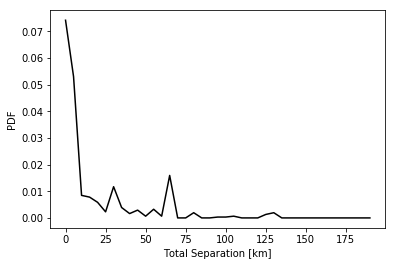

In [24]:
plt.plot(bins[:-1], pdf, 'k'); plt.xlabel('Total Separation [km]'); plt.ylabel('PDF');

In [25]:
# if WRITE_CDF_TO_FILE:
#     data = np.vstack((bins[:-1], cdf[:-1], pdf)).T
#     pd.DataFrame(data=data).to_csv('microburst_cdf_pdf_v0.csv', 
#                                    header=['Dist_Total', 'CDF', 'PDF'], index=False)

# Calculate the CDF Attempt 2
Here I attempt to account for the number of seconds that AC-6 took data togeather to remove a bias that comes from certain separations having more data than other separations. To take the exposure time into account, I reformulate the CDF in the following functional form

$$
CDF(d) = \frac{(coincident > d)/E(d, \inf)}{(all \ coincident)/E(0, \inf)} = \Big(\frac{(coincident > d)}{(all \ coincident)}\Big) \Big(\frac{E(0, \inf)}{E(d, \inf)}\Big)
$$

Visualize how the $E(0, \inf)/E(d, \inf)$ term looks like as a function of d

In [26]:
weights = [E.loc[0:500].sum()/E.loc[d:500].sum() for d in range(0, 201, 5)]

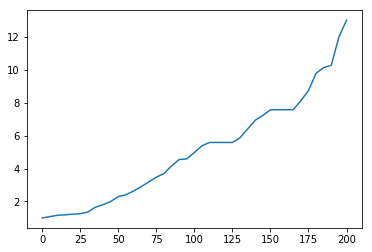

In [27]:
plt.plot(E.loc[0:200].index, weights);

In [28]:
cdf2 = np.array([(coincidentEvents['Dist_Total'] >= di).sum()/totalEvents*wi 
                 for di, wi in zip(bins, weights)])
cdf2 = cdf2.flatten()

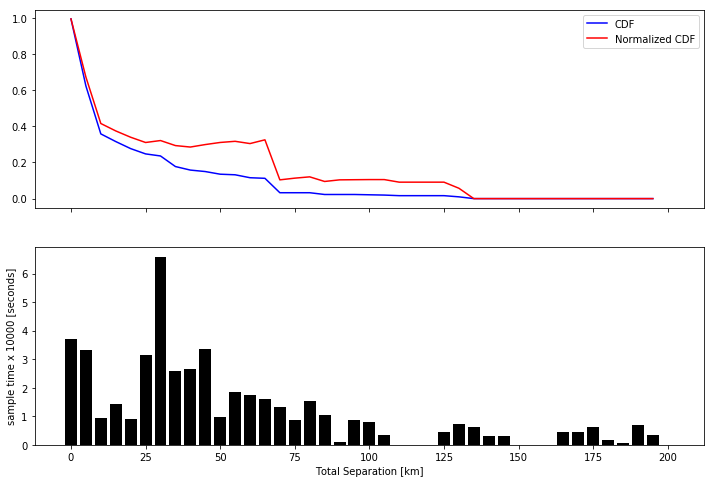

In [29]:
fig, ax = plt.subplots(2, sharex=True, figsize=(12, 8))
ax[0].plot(bins, cdf, 'b', label='CDF')
ax[0].plot(bins, cdf2, 'r', label='Normalized CDF')
ax[0].legend()
ax[1].bar(E.loc[0:200].index, E['Seconds'].loc[0:200]/10000, width=0.8*E.index[1]-E.index[0], color='k')
ax[1].set_ylabel('sample time x 10000 [seconds]'); ax[1].set_xlabel('Total Separation [km]');

In [30]:
(coincidentEvents['Dist_Total'] >= 100).sum()

13

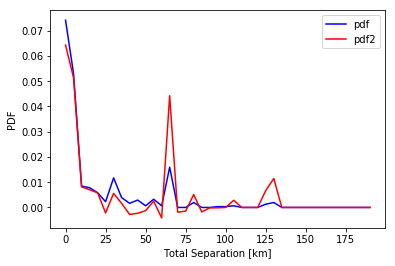

In [31]:
pdf2 = np.convolve([-1, 1], cdf2, mode='valid')/(E.index[1]-E.index[0])
plt.plot(bins[:-1], pdf, 'b', label='pdf')
plt.plot(bins[:-1], pdf2, 'r', label='pdf2')
plt.xlabel('Total Separation [km]'); plt.ylabel('PDF');
plt.legend();

In [32]:
if WRITE_CDF_TO_FILE:
    data = np.vstack((bins[:-1], cdf2[:-1], pdf2)).T
    df = pd.DataFrame(data=data, columns=['Dist_Total', 'CDF', 'PDF'])
    df.to_csv('microburst_cdf_pdf_norm_v0.csv', index=False)

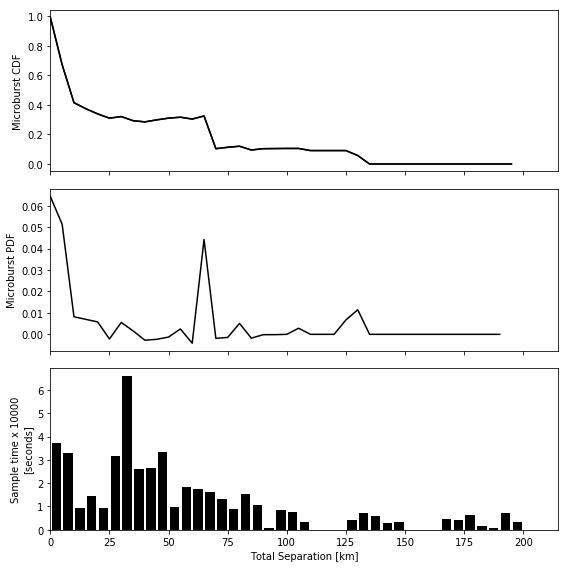

In [33]:
delta_bin = (E.index[1]-E.index[0])
fig, ax = plt.subplots(3, sharex=True, figsize=(8, 8))
ax[0].plot(bins, cdf2, 'k'); ax[0].set_ylabel('Microburst CDF')
ax[0].errorbar(bins, cdf2, c='k', yerr=0); ax[0].set_ylabel('Microburst CDF')
ax[1].plot(bins[:-1], pdf2, 'k'); ax[1].set_ylabel('Microburst PDF')
ax[2].bar(E.loc[0:200].index+0.5*delta_bin, E['Seconds'].loc[0:200]/10000, width=0.8*delta_bin, color='k')
ax[2].set_ylabel('Sample time x 10000\n[seconds]'); ax[2].set_xlabel('Total Separation [km]');
plt.tight_layout()
ax[0].set_xlim(left=0);
#plt.savefig('ac6_microburst_cdf_pdf.png')

# Calculate the CDF Attempt 3
Here I attempt to normalize each CDF bin between $d$ and $d + dt$ by the number of samples that AC-6 took data togeather in that bin. This may give the same result as Attempt 2.

$$
CDF(d) = \frac{N'(d)}{N'(0)}
$$ where $N'(d)$ is the adjusted number of detections made in the cumulative bin above a separation $d$. The normalization is then 
$$
N'(d) = \sum_{bin > d} N(bin) \ W_{bin}
$$ where $N(bin)$ is the number of microbursts in that bin (i.e. between 0 and 5 km), and $W_{bin}$ is the weight factor for that bin which is defined as, $W_{bin} = S_{max}/S_{bin}$. where $S_{max}$ is the bin with the largest number of samples, and $S_{bin}$ is the number of samples in the bin that corresponds to the weights.

In [99]:
# Number of coincident events between Dist_Total di and df. 
N_i = lambda di, df: sum((coincidentEvents['Dist_Total'] >= di) & 
                         (coincidentEvents['Dist_Total'] < df))
# Now apply the N_i function to all bin separations and make a numpy array.
N = np.array([N_i(bi, bf) for bi, bf in zip(bins[:-1], bins[1:])]).flatten()
# Calculate the weights normalized to the max number of samples (in the 30-35 km bin).
W = E['Seconds'].loc[0:190].max()/E['Seconds'].loc[0:190]
# The adjusted number of microbursts in each separation bin.
E2 = E.loc[0:190].copy()
E2.loc[:, 'N_prime'] = N*W

Last two lines above are to organize this nicely in a data frame. the .copy() is necessary since it is unclear if pandas will interpret E2 as a copy or a "view", http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#indexing-view-versus-copy 

In [100]:
cdf3 = np.array([np.nansum(E2.loc[d:190, 'N_prime'])/np.nansum(E2.loc[0:190, 'N_prime']) for d in bins]).flatten()
pdf3 = np.convolve([-1, 1], cdf3, mode='valid')/(E.index[1]-E.index[0])

(0, 190)

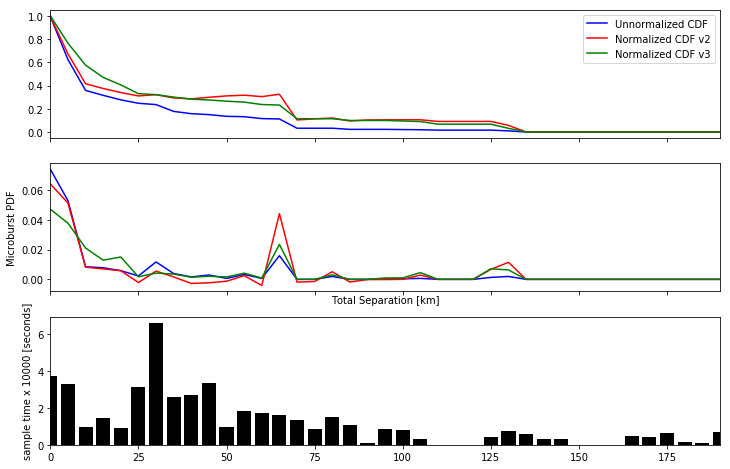

In [104]:
fig, ax = plt.subplots(3, sharex=True, figsize=(12, 8))
ax[0].plot(bins, cdf, 'b', label='Unnormalized CDF')
ax[0].plot(bins, cdf2, 'r', label='Normalized CDF v2')
ax[0].plot(bins, cdf3, 'g', label='Normalized CDF v3')
ax[0].legend()
ax[1].plot(bins[:-1], pdf, 'b'); 
ax[1].plot(bins[:-1], pdf2, 'r');
ax[1].plot(bins[:-1], pdf3, 'g');
ax[1].set_ylabel('Microburst PDF')
ax[2].bar(E.loc[0:200].index, E['Seconds'].loc[0:200]/10000, width=0.8*E.index[1]-E.index[0], color='k')
ax[2].set_ylabel('sample time x 10000 [seconds]'); ax[1].set_xlabel('Total Separation [km]');
ax[0].set_xlim(0, 190)

# Microburst Width Statistics
Investigate if there is a difference in widths between microbursts observed at the small and large separations.

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


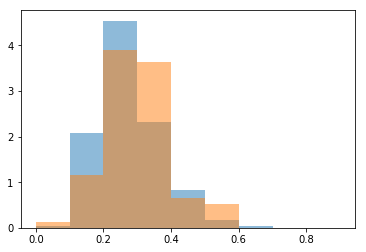

In [34]:
similar_width_events = coincidentEvents[np.isclose(
                            coincidentEvents['peak_width_A'], 
                            coincidentEvents['peak_width_B'], rtol=2)]
similar_width_events_small = similar_width_events[similar_width_events['Dist_Total'] < 10]
similar_width_events_large = similar_width_events[similar_width_events['Dist_Total'] > 50]

plt.hist(similar_width_events_small['peak_width_A'], bins=np.arange(0, 1, 0.1), normed=True, alpha=0.5);
plt.hist(similar_width_events_large['peak_width_A'], bins=np.arange(0, 1, 0.1), normed=True, alpha=0.5);

In [35]:
similar_width_events_small['peak_width_A'].mean()

0.2723467391656463